# Repeating Phrases

This notebook describes some strategies for working with repeating phrases (also called ngrams). It's part of the [The Art of Literary Text Analysis](ArtOfLiteraryTextAnalysis.ipynb) (and assumes that you've already worked through previous notebooks – see the table of contents). In this notebook we'll look in particular at

* NLTK Collocations (repeating pairs of words)
* NLTK NGrams (more flexible and powerful ngrams)
* simple distribution of phrases
* longest repeating phrases
* frequencies and distributions with segmented texts
* phrase frequency correlations

So far we've been focused on considering the frequency and distribution of individual terms, but sometimes it can also be useful to study repeating phrases, or sequences of words. Repeating phrases are sometimes also called n-grams where the "n" indicates a variable number of repeating words (or other linguistic unit like a character or ideogram). So we can have unigrams (one), bigrams (two), trigrams (three), and so on. The [Google Ngram Viewer](https://books.google.com/ngrams) provides a way of searching for variable length phrases in its very large corpus of digitized works. We'll consider here some of the ways of working with ngrams.

## NLTK Collocations

Let's begin by loading Austen's _Emma_ text from NLTK's Gutenberg corpus (we'll work with a longer text than _Gold Bug_ in order to see more repeating phrases).

In [205]:
import nltk
emmaTokens = list(nltk.corpus.gutenberg.words("austen-emma.txt")) # note the use of words() to load tokens
emmaWords = [word for word in emmaTokens if any([c for c in word if c.isalpha()])] # filter out non-words
print(emmaWords[:25])

['Emma', 'by', 'Jane', 'Austen', 'VOLUME', 'I', 'CHAPTER', 'I', 'Emma', 'Woodhouse', 'handsome', 'clever', 'and', 'rich', 'with', 'a', 'comfortable', 'home', 'and', 'happy', 'disposition', 'seemed', 'to', 'unite', 'some']


There's actually a very easy and convenient way to look for the top bigrams in an NLTK text using the ```collocations()``` function and specifying the number of top frequency phrases to return.

In [206]:
emmaText = nltk.Text(emmaWords)
emmaText.collocations(20) # 20 top bigrams separated by semi-colon

Mrs Weston; Frank Churchill; Miss Woodhouse; Mrs Elton; Miss Bates;
Jane Fairfax; Miss Fairfax; every thing; young man; every body; great
deal; Mrs Goddard; dare say; Maple Grove; John Knightley; Miss Taylor;
Miss Smith; Robert Martin; Colonel Campbell; Box Hill


A lot of proper names!

## NLTK NGrams

Though convenient, this method is limited to bigrams (2 words), forces the use of stopwords, and doesn't provide frequency information. Fortunately, with only a bit more work using NLTK's ```ngrams()``` function on a list of words, we have much more control. Let's create a temporary ngrams list to see what's happening.

In [207]:
emmaFirstSixWords = " ".join(emmaWords[:6]) # join first six words with spaces
print("first six words: ", emmaFirstSixWords)
emmaBigrams = list(nltk.ngrams(emmaWords, 2)) # create bigrams (ngrams of 2) from our emmaTokens
emmaBigrams[:5] # convert to a list and show the first 5 entries

first six words:  Emma by Jane Austen VOLUME I


[('Emma', 'by'),
 ('by', 'Jane'),
 ('Jane', 'Austen'),
 ('Austen', 'VOLUME'),
 ('VOLUME', 'I')]

As we can see, the ```nltk.ngrams()``` function goes through the text, and creates a new tupple of the specified length, with each item shifting forward by just one word – this is a moving window that slides along the entire text.

Since the last word of the text can't be the start of a bigram, we should have one fewer bigrams than words (even if all words but the last word are repeated in two entries, as the first word and as the second word).

In [208]:
print("number of words:", len(emmaWords))
print("number of ngrams:", len(emmaBigrams))

number of words: 161975
number of ngrams: 161974


Let's now look at ngrams of 4 tokens where we calculate frequency of repeating ngrams and ask for the most common.

In [209]:
emma4grams = list(nltk.ngrams(emmaWords, 4)) # create four-grams
emma4gramsFreqs = nltk.FreqDist(emma4grams) # determine frequency of four-grams
for words, count in emma4gramsFreqs.most_common(15): # for the 15 most common four-grams
    print(count, " ".join(list(words))) # show the count and the create a string from the tuple

50 I do not know
25 a great deal of
20 I am sure I
18 it would have been
18 Mr and Mrs Weston
18 I do not think
16 I am sure you
16 I have no doubt
14 at Mrs Goddard s
13 and I am sure
12 have no doubt of
12 I am sure she
12 that she could not
11 quarter of an hour
11 as soon as she


It's interesting that the phrase "I do not know" repeats so frequently. In fact, several of the entries relate to certainty or doubt, which would be worth looking at more closely. However, we should also notice another artefact of this simple ngram technique: we get overlapping entries. Consider the following two sentences:

* and I am sure I had no more idea…
* and I am sure I never think of that poor young man…

Our ```ngrams()``` function will actually find two ngrams of four:

* (2) and I am sure
* (2) I am sure I

Since these are separate entries and each entry has two occurrences, it might look like a total of four n-grams, but it's not necessarily valid to count them separately. Similarly, even though we have several entries above that related to doubt and certainty, it may be that some of them are composed of the same phrases in the text.

There are techniques to address this as a potential problem, but for now let's just be aware of the issue.

## Distribution of Phrases

We can't ask for a concordance or dispersion plot from the emmaText of our phrases, since our emmaText is composed of words (and a phrase can't match the words).

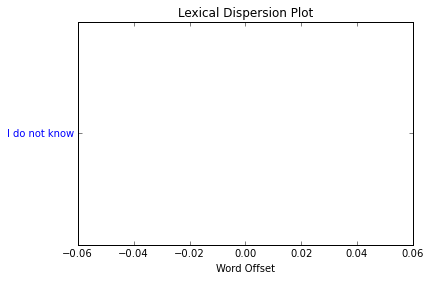

In [210]:
%matplotlib inline
emmaText.dispersion_plot(["I do not know"]) # won't work since phrases aren't in the emmaText tokens

However, we can create a new text from our ngrams and then ask for a dispersion plot. Don't forget that we need to search for the tuple ```("I","do","not","know")``` since that's what's in each ngram (not the string "I do not know").

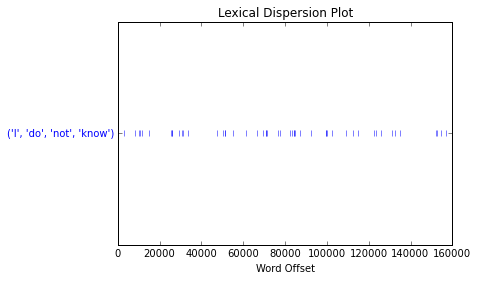

In [211]:
emma4gramsText = nltk.Text(emma4grams)
emma4gramsText.dispersion_plot([("I","do","not","know")])

We can perhaps perceive a greater preponderance of occurences closer to the middle of the text, but nothing especially noteworthy.

Rather than working with tuples, it may be easier to convert our ngram tuple to a string.

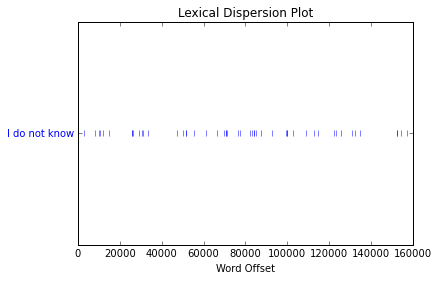

In [212]:
emma4gramsTokens = [" ".join(gram) for gram in emma4grams]
nltk.Text(emma4gramsTokens).dispersion_plot([("I do not know")])

## Longest Repeating Phrases

We might also want to determine the longest repeating ngrams. Using a range we can looking for ngrams and break out of the loop if there are no more.

In [227]:
ngramsFreqs = [] # keep track of last set of repeating phrases
for length in range(2, len(emmaWords)): # create a range from 2 to the length of the text (even if we don't get that high)
    ngrams = list(nltk.ngrams(emmaWords, length)) # get ngrams for specified length
    freqs = nltk.FreqDist(ngrams) # get frequencies for these ngrams
    freqs = [(ngram, count) for ngram, count in freqs.items() if count > 1] # filter out frequencies that don't repeat
    if len(freqs) > 0: # we have at least one repeating phrase
        ngramsFreqs = freqs # new set of frequencies
    else: # if we've filtered out all frequencies then break out of the loop
        break

for ngram, count in ngramsFreqs:
    print("ngram of ", len(ngram), " words occurring ", count, " times:", " ".join(list(ngram)))

ngram of  29  words occurring  2  times: what reverse we have Man s boasted power and freedom all are flown Lord of the earth and sea he bends a slave And woman lovely woman reigns alone


A repeating phrase of 29 words! We can look at _Emma_ closer to see that these are excerpts of a letter read in different contexts.

## Segmenting Texts

We've relied heavily on ```dispersion_plot()``` as a way of looking at term distribution, but there are other approaches, ones that may be better or worse depending on the context. One possibility is to segment our text into equal parts and then to plot distribution for each part.

We can segment our tokens or ngrams in various ways, but one convenient ways is to use a library called [NumPy](http://www.numpy.org) that is helpful for working with arrays (and graphing array-backed data). Let's see it in action with simplified example where we're going to create a list of numbers from 0 to 9 (10 elements) and then create 5 equal bins in which to place the items.

In [214]:
numbers = list(range(0,9)) # create a range from 0 to 9 and convert the range to a list
numbers

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [215]:
import numpy as np
numberBins = np.array_split(numbers, 5) # divide our numbers into 5 equal bins
print("number of bins:", len(numberBins))
numberBins

number of bins: 5


[array([0, 1]), array([2, 3]), array([4, 5]), array([6, 7]), array([8])]

So the first bin has 0 and 1, the second has 2 and 3, etc.

We can do something similar with our emma4gramsTokens, dividing the list into 10 each parts.

In [216]:
emma4gramsSegments = np.array_split(emma4gramsTokens, 10)
[len(segment) for segment in emma4gramsSegments] # how many ngrams in each bin?

[16198, 16198, 16197, 16197, 16197, 16197, 16197, 16197, 16197, 16197]

Now, instead of counting the number of tokens, we'll count the number of occurrences of our search term "I do not know".

In [217]:
iDoNotKnowCounts = [list(segment).count(("I do not know")) for segment in emma4gramsSegments]
iDoNotKnowCounts # counts per segment

[6, 6, 2, 5, 7, 7, 6, 4, 3, 4]

And now a simple plot of these counts (we're adding a legend to make it easier to understand).

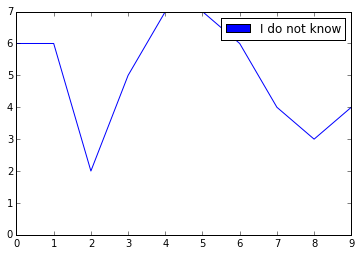

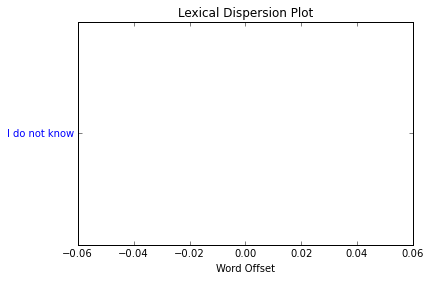

In [218]:
import matplotlib.pyplot as plt
line = plt.plot(iDoNotKnowCounts, label="I do not know")
plt.ylim(0) # make sure to set y axis to start at zero
plt.legend(handles=[bar]) # we're going to add a legend
plt.show() # make sure to flush out the line chart
emma4gramsText.dispersion_plot(["I do not know"]) # for comparison sake

These provide quite different pictures of the data even though in both cases we should be seeing 50 occurrences of "I do not know". The first graph seems to show wildly fluctuating numbers, but it's worth recognizing that in this simple form our y axis (vertical) only varies by five and that the numbers are relatively small. Indeed, it may not be all that helpful to use a line graph here since it suggests continuity between the segments when there isn't any. For discrete measurements, a bar graph is often preferable, and is only slights more complicated to produce, as we also provide explicit values for the x axis.

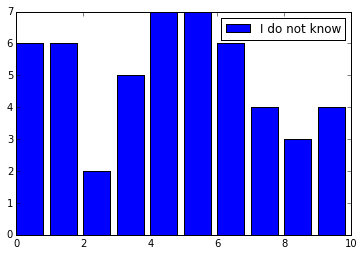

In [219]:
import matplotlib.pyplot as plt
xaxis = range(0, len(iDoNotKnowCounts)) # a range from zero to the length of our counts (0-9)
bar = plt.bar(xaxis, iDoNotKnowCounts, label="I do not know")
plt.legend(handles=[bar])
plt.show()

The xaxis (bottom horizontal bar) isn't quite ideal, but for now we can leave it as is.

Line graphs can be a bit easier to read for multiple values though. Let's construct a graph that compare "I do not know" and "I have no doubt".

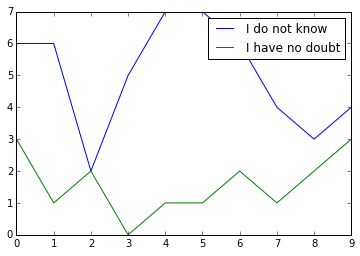

In [220]:
searches = ["I do not know", "I have no doubt"]
lines = []
for search in searches:
    line, = plt.plot([list(segment).count(search) for segment in emma4gramsSegments], label=search)
    lines.append(line)
plt.legend(handles=lines)
plt.show()

It's worth reiterating that the numbers here are very small, so we should probably resist the temptation to jump too much to conclusions.

## Correlations

A question we might have about the graph above is to what extent values in the two lines correlate. In other words, if one line rises, does the other have a tendency to rise, or is it the opposite, or is there no real correlation (synchronized variation) between the two.

Once again we can use NumPy to help us measure correlation using [corrcoef()](http://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html). Let's first see it in action with a couple of simple example datasets.

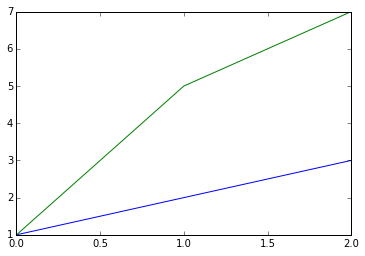

0.98198050606196585

In [232]:
list1 = [1,2,3]
list2 = [1,5,7]
plt.plot(range(3), list1, range(3), list2)
plt.show()
np.corrcoef(list1, list2)[0,1] # this returns a matrix (box) of values, but we're only interested in the top right value

This is a [correlation value](http://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient) that expresses the degree two which the values from the two lists change in harmony. For our purposes the underlying mathematics of it are somewhat less important than the general concept of correlation (synchrnized variation) and what the value essentially conveys.

Correlation values vary between -1 and 1. The correlation value in this case (0.98198050606196585) is approaching 1 which indicates a high correlation between the two lists (as the values in one list rise so do the ones in the other). Let's flip the order of the second list to see what happens.

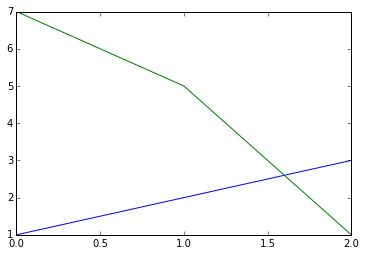

-0.98198050606196585

In [222]:
list2.reverse()
plt.plot(range(3), list1, range(3), list2)
plt.show()
np.corrcoef(list1, list2)[0,1]

Notice that we still have a strong correlation, but it's inverted (close to -1).

If items from our lists vary with little correlation, the correlation value will approach zero. Now let's try getting a correlation value for our two search terms.

In [229]:
iDoNotKnowCounts = [list(segment).count("I do not know") for segment in emma4gramsSegments]
iHaveNoDoubtCounts = [list(segment).count("I have no doubt") for segment in emma4gramsSegments]
print(iDoNotKnowCounts)
print(iHaveNoDoubtCounts)

[6, 6, 2, 5, 7, 7, 6, 4, 3, 4]
[3, 1, 2, 0, 1, 1, 2, 1, 2, 3]


In [230]:
np.corrcoef(iDoNotKnowCounts, iHaveNoDoubtCounts)[0,1]

-0.27066598098038336

So a weak inverse correlation (as the frequency of one rises or drops the other has a slight tendency to go int he opposite direction). Let's see if we can find one of our top frequeny four-grams with a stronger correlation.

In [225]:
emma4gramsMostFrequent = [" ".join(words) for words, count in emma4gramsFreqs.most_common(15)] # get a list of top 
print(emma4gramsMostFrequent)

['I do not know', 'a great deal of', 'I am sure I', 'it would have been', 'Mr and Mrs Weston', 'I do not think', 'I am sure you', 'I have no doubt', 'at Mrs Goddard s', 'and I am sure', 'have no doubt of', 'I am sure she', 'that she could not', 'quarter of an hour', 'as soon as she']


[('I do not know', 1.0), ('I do not think', 0.71679269233981702), ('I am sure you', 0.20299948573528753), ('I am sure she', 0.12110960264973429), ('and I am sure', 0.11275884962655314), ('it would have been', 0.082874193016474473), ('quarter of an hour', 0.054603247242463383), ('I am sure I', 0.041812100500354533), ('as soon as she', 0.0), ('Mr and Mrs Weston', -0.037330068339472139), ('I have no doubt', -0.27066598098038336), ('at Mrs Goddard s', -0.32003866823226162), ('have no doubt of', -0.35569399576529515), ('that she could not', -0.3797772626563749), ('a great deal of', -0.41344911529736156)]


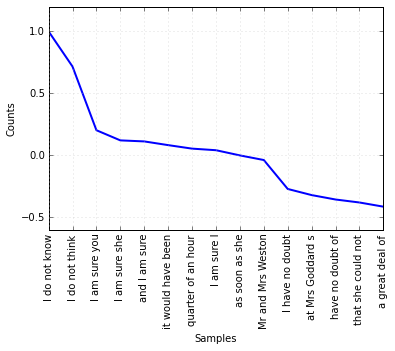

In [226]:
emma4gramsSegmentsCounts = {} # build a dictionary of counts for each search item
for search in emma4gramsMostFrequent:
    emma4gramsSegmentsCounts[search] = [list(segment).count(search) for segment in emma4gramsSegments]

iDoNotKnowCorrelations = {} # build a dictionary of correlation values for "I do not know"
for ngram, counts in emma4gramsSegmentsCounts.items():
    iDoNotKnowCorrelations[ngram] = np.corrcoef(emma4gramsSegmentsCounts["I do not know"], counts)[0,1]

iDoNotKnowCorrelationFreqs = nltk.FreqDist(iDoNotKnowCorrelations)
print(iDoNotKnowCorrelationFreqs.most_common())
iDoNotKnowCorrelationFreqs.plot()

"I do not know" correlates perfectly with "I do not know" (phew). But this also suggests that "I do not know" is positively correlated with "I do not think", followed by a bunch of weak correlations, and then some slightly stronger negative correlations for things like "a great deal of".

## Next Steps

* create an _emmaStoppedWords_ list that filters out stoplist words in _emmaWords_ (see [Getting NLTK](GettingNltk.ipynb#Word-Frequencies) if needed)
* compare the top 20 frequency ngrams from emmaWords and emmaStoppedWords – which seems more useful?
* using emmaStoppedWords determine the correlations between the top ngram and the top 20 ngrams (for 10 text segments)
* do the same, but with 100 text segments – does the ranking change?

---
From [The Art of Literary Text Analysis](ArtOfLiteraryTextAnalysis.ipynb) by [Stéfan Sinclair](http://stefansinclair.name) &amp; [Geoffrey Rockwell](http://geoffreyrockwell.com), [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/)<br />
Created February 24, 2015